In [1]:
import pandas as pd
data=pd.read_csv("/content/drive/MyDrive/Notebook/3667195.csv",index_col="DATE")

In [2]:
null_pct=data.apply(pd.isnull).sum()/data.shape[0]
valid_cols=data.columns[null_pct<=0.25]
print(valid_cols)

Index(['STATION', 'NAME', 'PRCP', 'SNOW', 'SNWD', 'TMAX', 'TMIN'], dtype='object')


In [3]:
data=data[valid_cols].copy()
data.columns=data.columns.str.lower()

In [4]:
data=data.ffill()

In [5]:
null_pct=data.apply(pd.isnull).sum()/data.shape[0]
print(null_pct)

station    0.0
name       0.0
prcp       0.0
snow       0.0
snwd       0.0
tmax       0.0
tmin       0.0
dtype: float64


In [6]:
data.index=pd.to_datetime(data.index)
print(data)

                station                           name  prcp  snow  snwd  \
DATE                                                                       
1970-01-01  USW00024233  SEATTLE TACOMA AIRPORT, WA US   0.0   0.0   0.0   
1970-01-02  USW00024233  SEATTLE TACOMA AIRPORT, WA US   0.0   0.0   0.0   
1970-01-03  USW00024233  SEATTLE TACOMA AIRPORT, WA US   0.0   0.0   0.0   
1970-01-04  USW00024233  SEATTLE TACOMA AIRPORT, WA US   0.0   0.0   0.0   
1970-01-05  USW00024233  SEATTLE TACOMA AIRPORT, WA US   0.0   0.0   0.0   
...                 ...                            ...   ...   ...   ...   
2024-04-15  USW00024233  SEATTLE TACOMA AIRPORT, WA US   0.0   0.0   0.0   
2024-04-16  USW00024233  SEATTLE TACOMA AIRPORT, WA US   0.0   0.0   0.0   
2024-04-17  USW00024233  SEATTLE TACOMA AIRPORT, WA US   0.0   0.0   0.0   
2024-04-18  USW00024233  SEATTLE TACOMA AIRPORT, WA US   0.0   0.0   0.0   
2024-04-19  USW00024233  SEATTLE TACOMA AIRPORT, WA US   0.0   0.0   0.0   

           

<Axes: xlabel='DATE'>

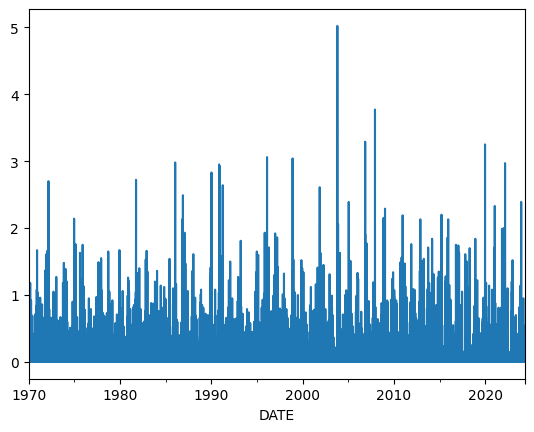

In [7]:
data["prcp"].plot()

In [8]:
data["target"]=data.shift(-1)["prcp"]

In [9]:
data

,station,name,prcp,snow,snwd,tmax,tmin,target
DATE,,,,,,,,
1970-01-01,USW00024233,"SEATTLE TACOMA AIRPORT, WA US",0.0,0.0,0.0,42.0,35.0,0.0
1970-01-02,USW00024233,"SEATTLE TACOMA AIRPORT, WA US",0.0,0.0,0.0,44.0,34.0,0.0
1970-01-03,USW00024233,"SEATTLE TACOMA AIRPORT, WA US",0.0,0.0,0.0,41.0,33.0,0.0
1970-01-04,USW00024233,"SEATTLE TACOMA AIRPORT, WA US",0.0,0.0,0.0,40.0,29.0,0.0
1970-01-05,USW00024233,"SEATTLE TACOMA AIRPORT, WA US",0.0,0.0,0.0,41.0,30.0,0.0
...,...,...,...,...,...,...,...,...
2024-04-15,USW00024233,"SEATTLE TACOMA AIRPORT, WA US",0.0,0.0,0.0,56.0,44.0,0.0
2024-04-16,USW00024233,"SEATTLE TACOMA AIRPORT, WA US",0.0,0.0,0.0,54.0,40.0,0.0
2024-04-17,USW00024233,"SEATTLE TACOMA AIRPORT, WA US",0.0,0.0,0.0,59.0,36.0,0.0


In [10]:
data=data.ffill()

In [11]:
from sklearn.linear_model import Ridge
rr=Ridge(alpha=.1)

In [12]:
predictors=data.columns[~data.columns.isin(["target","name","station"])]
print(predictors)

Index(['prcp', 'snow', 'snwd', 'tmax', 'tmin'], dtype='object')


In [13]:
def backtest(data,model,predictors,start=3650,step=90):
  all_predictors=[]
  for i in range(start,data.shape[0],step):
    train=data.iloc[:i,:]
    test=data.iloc[i:(i+step),:]
    model.fit(train[predictors],train["target"])
    pred=model.predict(test[predictors])
    pred=pd.Series(pred,index=test.index)
    combined=pd.concat([test["target"],pred],axis=1)
    combined.columns=["actual","prediction"]
    combined["diff"]=(combined["actual"]-combined["prediction"]).abs()
    all_predictors.append(combined)
  return pd.concat(all_predictors)

In [14]:
predictions=backtest(data,rr,predictors)

In [15]:
predictions

,actual,prediction,diff
DATE,,,
1979-12-30,0.21,0.188230,0.021770
1979-12-31,0.22,0.156252,0.063748
1980-01-01,0.19,0.168913,0.021087
1980-01-02,0.00,0.167542,0.167542
1980-01-03,0.13,0.103271,0.026729
...,...,...,...
2024-04-15,0.00,0.093245,0.093245
2024-04-16,0.00,0.089093,0.089093
2024-04-17,0.00,0.050627,0.050627


In [16]:
from sklearn.metrics import mean_absolute_error
mean_absolute_error(predictions["actual"], predictions["prediction"])

0.1254270594544478

In [17]:
pd.Series(rr.coef_, index=predictors)

prcp    0.268340
snow   -0.008729
snwd   -0.000577
tmax   -0.004902
tmin    0.003489
dtype: float64

In [18]:
def pctdiff(old,new):
  return (new-old)/old
def compute_rolling(data,horizon,col):
  label=f"rolling_{horizon}_{col}"
  data[label] = data[col].rolling(horizon).mean()
  data[f"{label}_pct"]=pctdiff(data[label],data[col])
  return data
rolling_horizon=[3,14]
for h in rolling_horizon:
  for col in ["tmax","tmin","prcp"]:
    data=compute_rolling(data,h,col)

In [19]:
data

,station,name,prcp,snow,snwd,tmax,tmin,target,rolling_3_tmax,rolling_3_tmax_pct,rolling_3_tmin,rolling_3_tmin_pct,rolling_3_prcp,rolling_3_prcp_pct,rolling_14_tmax,rolling_14_tmax_pct,rolling_14_tmin,rolling_14_tmin_pct,rolling_14_prcp,rolling_14_prcp_pct
DATE,,,,,,,,,,,,,,,,,,,,
1970-01-01,USW00024233,"SEATTLE TACOMA AIRPORT, WA US",0.0,0.0,0.0,42.0,35.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1970-01-02,USW00024233,"SEATTLE TACOMA AIRPORT, WA US",0.0,0.0,0.0,44.0,34.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1970-01-03,USW00024233,"SEATTLE TACOMA AIRPORT, WA US",0.0,0.0,0.0,41.0,33.0,0.0,42.333333,-0.031496,34.000000,-0.029412,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1970-01-04,USW00024233,"SEATTLE TACOMA AIRPORT, WA US",0.0,0.0,0.0,40.0,29.0,0.0,41.666667,-0.040000,32.000000,-0.093750,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1970-01-05,USW00024233,"SEATTLE TACOMA AIRPORT, WA US",0.0,0.0,0.0,41.0,30.0,0.0,40.666667,0.008197,30.666667,-0.021739,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-04-15,USW00024233,"SEATTLE TACOMA AIRPORT, WA US",0.0,0.0,0.0,56.0,44.0,0.0,61.333333,-0.086957,43.000000,0.023256,0.0,NaN,55.785714,0.003841,42.571429,0.033557,0.028571,-1.0
2024-04-16,USW00024233,"SEATTLE TACOMA AIRPORT, WA US",0.0,0.0,0.0,54.0,40.0,0.0,58.333333,-0.074286,42.333333,-0.055118,0.0,NaN,54.857143,-0.015625,42.214286,-0.052453,0.027143,-1.0
2024-04-17,USW00024233,"SEATTLE TACOMA AIRPORT, WA US",0.0,0.0,0.0,59.0,36.0,0.0,56.333333,0.047337,40.000000,-0.100000,0.0,NaN,55.285714,0.067183,41.785714,-0.138462,0.027143,-1.0


In [20]:
data=data.fillna(0)

In [21]:
def expandmean(data):
  return data.expanding(1).mean()
for col in["tmax","tmin","prcp"]:
  data[f"monthavg_{col}"]=data[col].groupby(data.index.month,group_keys=False).apply(expandmean)
  data[f"day_avg_{col}"] = data[col].groupby(data.index.day_of_year, group_keys=False).apply(expandmean)

In [22]:
data

,station,name,prcp,snow,snwd,tmax,tmin,target,rolling_3_tmax,rolling_3_tmax_pct,...,rolling_14_tmin,rolling_14_tmin_pct,rolling_14_prcp,rolling_14_prcp_pct,monthavg_tmax,day_avg_tmax,monthavg_tmin,day_avg_tmin,monthavg_prcp,day_avg_prcp
DATE,,,,,,,,,,,,,,,,,,,,,
1970-01-01,USW00024233,"SEATTLE TACOMA AIRPORT, WA US",0.0,0.0,0.0,42.0,35.0,0.0,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.0,42.000000,42.000000,35.000000,35.000000,0.000000,0.000000
1970-01-02,USW00024233,"SEATTLE TACOMA AIRPORT, WA US",0.0,0.0,0.0,44.0,34.0,0.0,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.0,43.000000,44.000000,34.500000,34.000000,0.000000,0.000000
1970-01-03,USW00024233,"SEATTLE TACOMA AIRPORT, WA US",0.0,0.0,0.0,41.0,33.0,0.0,42.333333,-0.031496,...,0.000000,0.000000,0.000000,0.0,42.333333,41.000000,34.000000,33.000000,0.000000,0.000000
1970-01-04,USW00024233,"SEATTLE TACOMA AIRPORT, WA US",0.0,0.0,0.0,40.0,29.0,0.0,41.666667,-0.040000,...,0.000000,0.000000,0.000000,0.0,41.750000,40.000000,32.750000,29.000000,0.000000,0.000000
1970-01-05,USW00024233,"SEATTLE TACOMA AIRPORT, WA US",0.0,0.0,0.0,41.0,30.0,0.0,40.666667,0.008197,...,0.000000,0.000000,0.000000,0.0,41.600000,41.000000,32.200000,30.000000,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-04-15,USW00024233,"SEATTLE TACOMA AIRPORT, WA US",0.0,0.0,0.0,56.0,44.0,0.0,61.333333,-0.086957,...,42.571429,0.033557,0.028571,-1.0,58.033028,58.218182,42.290520,42.763636,0.092557,0.094364
2024-04-16,USW00024233,"SEATTLE TACOMA AIRPORT, WA US",0.0,0.0,0.0,54.0,40.0,0.0,58.333333,-0.074286,...,42.214286,-0.052453,0.027143,-1.0,58.030562,57.945455,42.289120,42.290909,0.092500,0.079818
2024-04-17,USW00024233,"SEATTLE TACOMA AIRPORT, WA US",0.0,0.0,0.0,59.0,36.0,0.0,56.333333,0.047337,...,41.785714,-0.138462,0.027143,-1.0,58.031155,57.727273,42.285278,42.454545,0.092443,0.068364


In [23]:
predictors=data.columns[~data.columns.isin(["target","name","station"])]

In [24]:
predictions=backtest(data,rr,predictors)

In [25]:
predictions

,actual,prediction,diff
DATE,,,
1979-12-30,0.21,0.252596,0.042596
1979-12-31,0.22,0.196389,0.023611
1980-01-01,0.19,0.190093,0.000093
1980-01-02,0.00,0.138975,0.138975
1980-01-03,0.13,0.077418,0.052582
...,...,...,...
2024-04-15,0.00,0.051870,0.051870
2024-04-16,0.00,0.033238,0.033238
2024-04-17,0.00,0.022041,0.022041


In [26]:
mean_absolute_error(predictions["actual"], predictions["prediction"])

0.12121732733318123

In [27]:
predictions.sort_values("diff",ascending=False)

,actual,prediction,diff
DATE,,,
2003-10-19,5.02,0.143789,4.876211
2007-12-02,3.77,0.461899,3.308101
2006-11-05,3.29,0.392528,2.897472
1998-11-24,3.04,0.220607,2.819393
2019-12-19,3.25,0.438078,2.811922
...,...,...,...
1992-08-27,0.00,0.000040,0.000040
1996-07-26,0.00,0.000037,0.000037
2007-07-08,0.00,-0.000024,0.000024


<Axes: xlabel='DATE'>

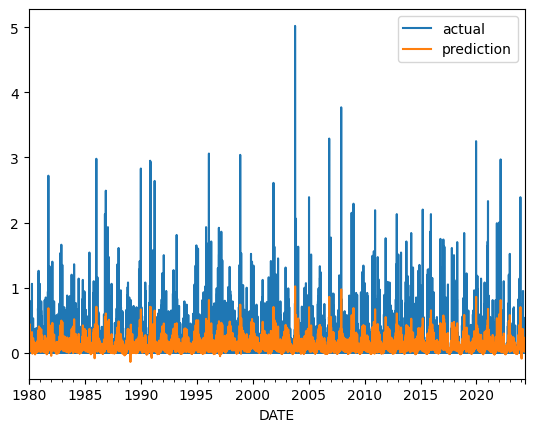

In [28]:
predictions[["actual", "prediction"]].plot()